In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pycryptodome numpy matplotlib pwntools

Defaulting to user installation because normal site-packages is not writeable


# AES

## Introduction

In 1997 the NIST calls for proposal for a new cryptosystem to replace DES and 3DES. An open process started including the whole international scientific community.

In 2001 the [_Rijndael_](https://nvlpubs.nist.gov/nistpubs/fips/nist.fips.197.pdf) cipher is chosen as the new _Advanced Encryption Standard_ AES. The cipher had been invented by Joan Daemen and Vincent Rijmen from Belgium.

Other candidate ciphers were proposed : Mars by IBM, RC6 by RSA Laboratories, [Serpent](https://www.cl.cam.ac.uk/~rja14/serpent.html) by Anderson, Biham and Knudsen and [Twofish](https://www.schneier.com/academic/archives/1998/12/the_twofish_encrypti.html) by Schneier and others.

In 2001 AES is approved as a US federal standard. In 2003 the NSA allows AES to encrypt TOP SECRET documents.

## Overview of AES

AES is a block cipher operating on blocks of 128 bits. It accepts keys of size 128, 192 or 256 bits.

<img src="figures/figure_01.png" alt="drawing" width="400"/>

Note : the size of the key does not change the size of the blocks, it is always 128 bits for AES.

## Structure of AES

### Encryption

AES performs operations on both the key and the plaintext in rounds. Each round consists of operations on the key and on the plaintext that can be performed in parralel and are "combined" at the end of the round.

Depending on the length of the key, AES will perform 10 rounds (128 bits key), 12 rounds (192 bits key) or 14 rounds (256 bits key).

The plaintext is cut in blocks of 128 bits and each block is visualized as a 4 by 4 matrix of bytes.

<img src="figures/figure_02.png" alt="drawing" width="200"/>

Each round of operations on a block consists of three layers :
- XOR with the round key (obtained as the result of the key derivation schedule)
- Substitution layer (S-box) changing the bytes to add _confusion_
- Diffusion layer mixing rows and columns to add _diffusion_

Each round of operation on the key aims at producing a 128 bits round key from the original key.

Note : the size of the round key is always the same size as the block (128 bits) regardless of the size of the original key.

<img src="figures/figure_03.png" alt="drawing" width="600"/>

<img src="figures/figure_04.png" alt="drawing" width="700"/>


### Decryption

The key schedule can be computed independently and all the operations on the cipher text are invertible.

## Additional notes

- Computations are done over a Galois field $GF(2^8)$
- As AES was defined as a standard is has been implemented in hardware
- As of today there are no known efficient attacks on AES itself (vulnerabilities exist in some modes of operations)

## Python example

In [2]:
from Crypto.Cipher import AES
from math import ceil

# As specified, the supported key lengths are 128, 192 and 256 bits
# For a start, use a 128 bits = 16 bytes key
# Reminder : in ASCII, one byte is one character
key = b'Sixteen byte key'
assert len(key) == 16

# Use the AES cryptosystem in ECB mode (see later for an explanation about ECB)
# Use the previously defined key
cipher = AES.new(key, AES.MODE_ECB)

# For a simple example we use a 128 bits plaintext to fit everything in one block
# If the plaintext is shorter, padding is used
# If the plaintext is longer, it will be split in multiple blocks
plaintext = 'hello world text'
print(f"The plaintext is '{plaintext}' and is {len(plaintext)}bytes long. It will fit in {ceil(len(plaintext)/16)} block(s).")

# To encrypt use the encrypt method
# it expects a bytes object so the plaintext needs to be encoded
encrypted = cipher.encrypt(plaintext.encode())
print(f"The encrypted ciphertext is {encrypted}. It probably can't be decoded and should look like random bytes.")

decrypted = cipher.decrypt(encrypted)
print(f"The decrypted ciphertext is '{decrypted.decode()}'. It should be the same as the original plaintext.")

The plaintext is 'hello world text' and is 16bytes long. It will fit in 1 block(s).
The encrypted ciphertext is b'2\xb4f2\x18\x91\x0bi\x16\xe3\x8e\xcb\n/\xb11'. It probably can't be decoded and should look like random bytes.
The decrypted ciphertext is 'hello world text'. It should be the same as the original plaintext.


## OpenSSL example

The following command should produce the same effect as in the Python example.

```shell
# encryption
echo -n "hello world text" | openssl enc -e -aes-128-ecb -nosalt -nopad -K 5369787465656e2062797465206b6579 -in - -out excrypted

# decryption
openssl enc -d -aes-128-ecb -nosalt -nopad -K 5369787465656e2062797465206b6579 -in encrypted | xxd
```

Note : To generate the key from the terminal use the command `od`. Be careful to remove the spaces to use with openSSL.
```shell
echo -n "Sixteen byte key" | od -A d -t x1z -
```

# Modes of operation

Modes of operation describe the process used to encrypt a plaintext $p$ with a block cipher $c$ and a key $k$.

## ECB (Electronic Code Book)

ECB is a _block cipher_. The encryption operation is only defined over blocks of 128 bits. If the length of the plaintext is not a multiple of 128 bits, some padding is necessary.

In ECB, the plaintext is split into blocks $b_i$ and each block is encrypted into $b'_i$ the same way using the encryption algorithm and the key.

$$
\begin{cases}
b'_i = c(b_i,k)\\
b_i = c^{-1}(b'_i,k)
\end{cases}
$$

<img src="figures/figure_05.png" alt="drawing" width="700"/>

Remarks :
- All blocks are encrypted independently. The content of one block does not impact the encryption of the others (not much diffusion).
- Two identical blocks are encrypted into the same ciphertext.

## CBC (Cipher Block Chaining)

CBC is also a block cipher.

In CBC, each block in XORed with the previous cipher before being encrypted.

<img src="figures/figure_06.png" alt="drawing" width="700"/>

Remarks :
- Blocks have to be computed sequentially.
- Two identical blocks will not give the same ciphertext. There is diffusion in the ciphertext.

## OFB (Output FeedBack)

OFB is a _stream cipher_. The encryption process is defined over plaintexts of arbitrary size without padding.

In OFB, an _initialization vector_ (IV) is encrypted and the output is XORed with the plaintext. The following block uses the encrypted IV as a new IV for the block.

<img src="figures/figure_07.png" alt="drawing" width="700"/>

Remarks :
- The stream of encryption bits can be computed independently of the plaintext. This means it can be computed in advance to make the encryption faster.
- In OFB, the encryption does not come from the encryption algorithm but from the XOR. The encryption algorithm is needed to give seemingly random bits to XOR.

# ECB vs CBC and the penguin problem

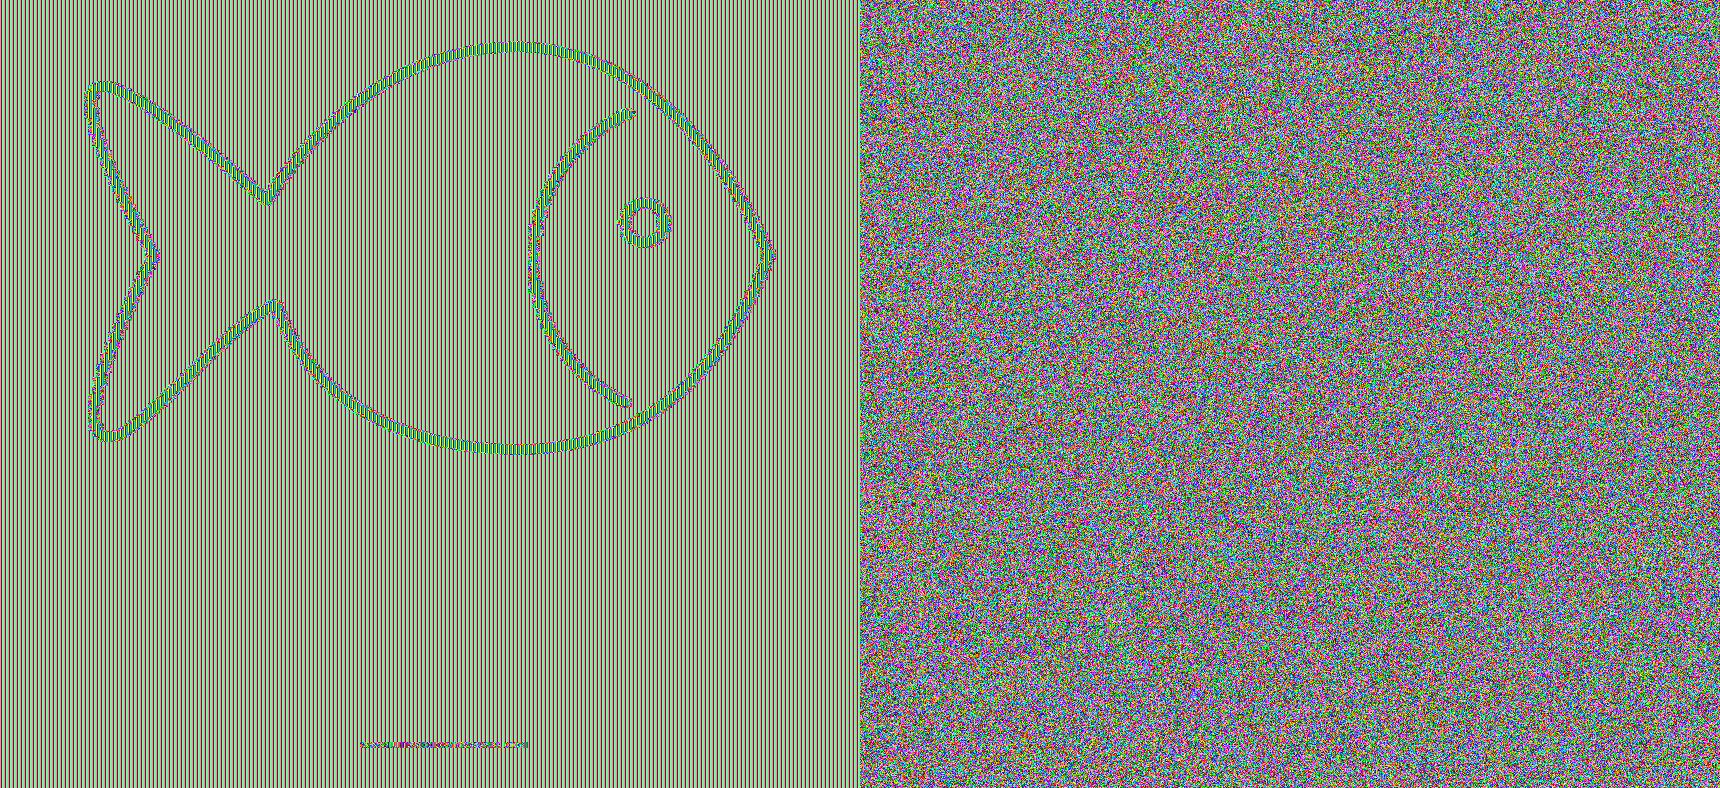

In [7]:
from PIL import Image
from Crypto.Cipher import AES
import numpy as np

def encrypt_ECB(msg, key = b'Sixteen byte key'):
    assert isinstance(key, bytes) and len(key)==16
    cipher = AES.new(key, AES.MODE_ECB)
    return(cipher.encrypt(msg))

def encrypt_CBC(msg, key = b'Sixteen byte key'):
    assert isinstance(key, bytes) and len(key)==16
    cipher = AES.new(key, AES.MODE_CBC)
    return(cipher.encrypt(msg))

im = Image.open("figures/fish.png")

pixels = list(im.getdata())

flat_pixels = bytes([val for elem in pixels for val in elem])
ECB_encrypted_flat_pixels = encrypt_ECB(flat_pixels)
CBC_encrypted_flat_pixels = encrypt_CBC(flat_pixels)

ECB_encrypted_pixels = [tuple(ECB_encrypted_flat_pixels[i:i+4]) for i in range(0, len(ECB_encrypted_flat_pixels), 4)]
CBC_encrypted_pixels = [tuple(CBC_encrypted_flat_pixels[i:i+4]) for i in range(0, len(CBC_encrypted_flat_pixels), 4)]

ECB_img = Image.new('RGB', im.size)
ECB_img.putdata(ECB_encrypted_pixels)

CBC_img = Image.new('RGB', im.size)
CBC_img.putdata(CBC_encrypted_pixels)

#ECB_img.show()
#CBC_img.show()

Image.fromarray(np.hstack((np.array(ECB_img),np.array(CBC_img)))).show()

# ECB vs the bank

A bank uses a simple messaging protocol to get transfer orders from clients :

`
sender account number (16 characters) | recipient account number (16 characters) | transfer amount (padded to 16 characters)
`

For example Alice (account number `1099583068280986`) can send 10 to Bob (account number `2763032106689792`) with the message `109958306828098627630321066897920000000000000010`.

For security purposes the messages are encrypted using AES_ECB with a key that both Alice and the bank agreed upon. For example, using a secret key, the previous transaction would be sent as `b'\x88-A\xfd\xfa\t\xd5A\x05\xd1@\xfc\x84.\x18u\xf5/C&L\xf95\\\t\x86\x8e\x11\xb3\xf8\xc5\x97\x9b\xcdi\x85\x10l\x10T\x0f)\xae\x81h\xa7e\x83'`.

Suppose Bob intercepts a message from Alice to her bank for a transfer to Charlie with the same key. Without knowing the key, can Bob steal the funds ?

The message intercepted by Bob is `b'\x88-A\xfd\xfa\t\xd5A\x05\xd1@\xfc\x84.\x18uH\xbf\xec\x9a\xbe\x08u:Y6\xfa\xcb=\xc1\x9e|\x9b\xcdi\x85\x10l\x10T\x0f)\xae\x81h\xa7e\x83'`.

In [4]:
class Transfer():
    def __init__(self, sender = None, receiver = None, amount = 0):
        self.sender   = sender
        self.receiver = receiver
        self.amount   = amount
    
    def __repr__(self):
        return(f"\nTransfer :\n{self.sender}\nsent {self.amount} to\n{self.receiver}\n")
    
    def encrypt(self, key = b'Sixteen byte key'):
        assert isinstance(key, bytes) and len(key)==16
        cipher        = AES.new(key, AES.MODE_ECB)
        msg           = f"{self.sender}{self.receiver}{self.amount:016}".encode()
        encrypted_msg = cipher.encrypt(msg)
        return(encrypted_msg)
    
    def decrypt(self, msg, key = b'Sixteen byte key'):
        assert isinstance(key, bytes) and len(key)==16
        cipher        = AES.new(key, AES.MODE_ECB)
        decrypted_msg = cipher.decrypt(msg)
        self.sender   = decrypted_msg[0:16].decode()
        self.receiver = decrypted_msg[16:32].decode()
        self.amount   = int(decrypted_msg[32:].decode())
        return(self.__repr__())

alice   = 1099583068280986
bob     = 2763032106689792
charlie = 6523482882776986

a_to_b = Transfer(alice, bob, 10)
print(a_to_b)
msg_a_to_b = a_to_b.encrypt()
print(f"Encrypted message : {msg_a_to_b}")

a_to_c = Transfer(alice, charlie, 100)
print(a_to_c)
msg_a_to_c = a_to_c.encrypt()
print(f"Encrypted message : {msg_a_to_c}")

malicious = msg_a_to_c[0:16] + msg_a_to_b[16:32] + msg_a_to_c[32:]

print(a_to_c.decrypt(malicious))


Transfer :
1099583068280986
sent 10 to
2763032106689792

Encrypted message : b'\x88-A\xfd\xfa\t\xd5A\x05\xd1@\xfc\x84.\x18u\xf5/C&L\xf95\\\t\x86\x8e\x11\xb3\xf8\xc5\x97\x9b\xcdi\x85\x10l\x10T\x0f)\xae\x81h\xa7e\x83'

Transfer :
1099583068280986
sent 100 to
6523482882776986

Encrypted message : b'\x88-A\xfd\xfa\t\xd5A\x05\xd1@\xfc\x84.\x18uH\xbf\xec\x9a\xbe\x08u:Y6\xfa\xcb=\xc1\x9e|L\xbc\xde\x8b\xf6\x7fg\x9eY\x16g\xce\xde\xb4\xed3'

Transfer :
1099583068280986
sent 100 to
2763032106689792



# CBC vs the bank

The same bank has now upgraded its security and uses CBC for the encryption.

The bank also introduced a new feature : senders can now add a comment to remember what the transfer was for. The new format for messages is now :

`
sender account number (16 characters) | recipient account number (16 characters) | comment (right padded to 16 characters) | transfer amount (padded to 16 characters)
`

Alice sends a transfer to Bob. Without knowing the key, can Bob steal money from Alice ?

In [5]:
from pwn import *

iv =  b'garbagevaluesxxx'

class Transfer():
    def __init__(self, sender = None, receiver = None, amount = 0, comment = "deadbeef"):
        self.sender   = sender
        self.receiver = receiver
        self.comment  = comment.rjust(16,'0')
        self.amount   = amount
    
    def __repr__(self):
        return(f"\nTransfer :\n{self.sender}\nsent {self.amount} to\n{self.receiver}\nComment : {self.comment}\n")
    
    def encrypt(self, key = b'Sixteen byte key'):
        assert isinstance(key, bytes) and len(key)==16
        cipher        = AES.new(key, AES.MODE_CBC, iv)
        msg           = f"{self.sender}{self.receiver}{self.comment}{self.amount:016}".encode()
        encrypted_msg = cipher.encrypt(msg)
        return(encrypted_msg)
    
    def decrypt(self, msg, key = b'Sixteen byte key'):
        assert isinstance(key, bytes) and len(key)==16
        cipher        = AES.new(key, AES.MODE_CBC, iv)
        decrypted_msg = cipher.decrypt(msg)
        self.sender   = decrypted_msg[0:16].decode()
        self.receiver = decrypted_msg[16:32].decode()
        self.comment  = decrypted_msg[32:48]
        self.amount   = int(decrypted_msg[48:])
        return(self.__repr__())

alice   = 1099583068280986
bob     = 2763032106689792

a_to_b = Transfer(alice, bob, 100)
print(a_to_b)
msg_a_to_b = a_to_b.encrypt()
print(f"Encrypted message : {msg_a_to_b}")

evil = msg_a_to_b[:32] + xor(msg_a_to_b[32:48], b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00') + msg_a_to_b[48:]

print(a_to_b.decrypt(evil))


Transfer :
1099583068280986
sent 100 to
2763032106689792
Comment : 00000000deadbeef

Encrypted message : b'\xf19\xbe\x001\x84\xb59\x8d\xff\x808f\xb8\xd9Z\xcc|5n\x98\x02{\x05\xa9\xfc\xcf\x8e\x85q\x07\x16\xae\xb7\x06}\xd0\x17\xf9\tD:\x02\x8eJ>\xb7\xb8\xa9\xec\xb8_\x93KvY\xab\xdf\x7f\xef#\xce\xc4^'

Transfer :
1099583068280986
sent 1100 to
2763032106689792
Comment : b"\x04\x01\xb1\xeb\xd9\xee\x07=\xb6\x84\xd6'\xe0\x9c\x0e\xbc"

